In [ ]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='ba30ce5e-7ca5-4e61-ac20-b9ede336330c', project_access_token='p-d513e7b683ee53adb8fb0765b894d8da1962b952')
pc = project.project_context


# MARATONA BEHIND THE CODE 2020

## DESAFIO 6 - ANAHUAC

### Introducción

En este desafio, usted usará herramientas de IBM como Watson Studio (o Cloud Pak for Data) para construir un modelo baseado en Machine Learning capaz de preveer si un estudante irá continuar o abandonará su curso.

<hr>

## Installing Libs

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
!pip install xgboost --upgrade

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<hr>

## Loading the .csv dataset from GitHub

In [2]:
import pandas as pd
import numpy as np

In [225]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/ForTraining.csv
df_base_for_training = pd.read_csv(r'ForTraining.csv')
df_base_for_training.head()

--2020-09-18 06:46:06--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/ForTraining.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92376 (90K) [text/plain]
Saving to: ‘ForTraining.csv.4’

ForTraining.csv.4   100%[===================>]  90.21K  --.-KB/s    in 0.03s   

2020-09-18 06:46:06 (2.94 MB/s) - ‘ForTraining.csv.4’ saved [92376/92376]



,studentId,reducido,ciclo,Graduado
0,88588.0,Interv. Edu.,2019 - 08,No
1,81135.0,Educacion,2019 - 05,Si
2,80926.0,Direc. Estrat. Neg,2019 - 05,Si
3,82415.0,B. I.,2019 - 06,Si
4,90082.0,Est. Temprana,2019 - 08,No


In [48]:
df_base_for_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studentId  2500 non-null   float64
 1   reducido   2500 non-null   object 
 2   ciclo      2500 non-null   object 
 3   Graduado   2500 non-null   object 
dtypes: float64(1), object(3)
memory usage: 78.2+ KB


In [49]:
df_base_for_training.nunique()

studentId    2500
reducido       88
ciclo          22
Graduado        2
dtype: int64

Descripción: La primera tabla mostrada arriba tiene 4 columnas, 3 son features and el target: `Graduado` that has a binary values={Si, No}.

Usted puede, y debe, usar mas data que esta disponible para construir su modelo. Los siguientes archivos .csv presentados:

In [226]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/OrdenMaterias.csv
df_orden_materias = pd.read_csv(r'OrdenMaterias.csv')
df_orden_materias.head(8)

--2020-09-18 06:46:12--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/OrdenMaterias.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63920 (62K) [text/plain]
Saving to: ‘OrdenMaterias.csv.4’

OrdenMaterias.csv.4 100%[===================>]  62.42K  --.-KB/s    in 0.03s   

2020-09-18 06:46:12 (2.31 MB/s) - ‘OrdenMaterias.csv.4’ saved [63920/63920]



,reducido,2017 - 03,2017 - 04,2017 - 05,2017 - 06,2017 - 07,2017 - 08,2018 - 01,2018 - 02,2018 - 03,2018 - 04,2018 - 05,2018 - 06,2018 - 07,2018 - 08,2019 - 01,2019 - 02,2019 - 03,2019 - 04,2019 - 05,2019 - 06,2019 - 07,2019 - 08,2020 - 01,2020 - 02,2020 - 03,2020 - 04,2020 - 05,2020 - 06
0,Act. Derecho Contratual,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Consentimiento y objeto digital contractual,Métodos alternos de resolución de controversias,Nueva clasificación contractual,Nuevo derecho probatorio documental,Contratos inteligentes,Consentimiento y objeto digital contractual
1,Adm. Emp.,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Mercadotecnia Estratégica,Contabilidad Financiera y Presupuestos,Administración de costos,Impuestos,Desafíos actuales en la Dirección del Capital ...,Mercadotecnia Estratégica,Contabilidad Financiera y Presupuestos,Administración de costos,Impuestos,Desafíos actuales en la Dirección del Capital ...
2,Adm. Riesgos,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Riesgos empresariales,Contabilidad Financiera y Presupuestos,Administración de riesgos,Evaluación de Riesgos,Toma de Decisiones,Riesgos empresariales,Contabilidad Financiera y Presupuestos,Administración de riesgos,Evaluación de Riesgos,Toma de Decisiones
3,Adm. Salud,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Calidad en salud,Contabilidad Financiera y Presupuestos,Administración de costos,Salud pública,Planeación estratégica en salud,Calidad en salud,Contabilidad Financiera y Presupuestos,Planeación estratégica en salud,Salud pública,Planeación estratégica en salud
4,Admon Fin.,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Decisión y Análisis de Inversión,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...,Decisión y Análisis de Inversión,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...,Decisión y Análisis de Inversión,Decisión de Financiamiento y Pago de Dividendos,Análisis de Estados Financieros,Estrategias de negocios,Planeación Financiera y Administración del Cap...
5,Alim. Y Nut. Salud,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Ambiente y conductas obesogénicas,Antecedentes y evolución de la alimentación,Composición corporal y metabolismo,Trastornos de la conducta alimentaria (TCA),"Alimentación, crecimiento y desarrollo",Ambiente y conductas obesogénicas,Antecedentes y evolución de la alimentación,Composición corporal y metabolismo,Trastornos de la conducta alimentaria (TCA),"Alimentación, crecimiento y desarrollo",Ambiente y conductas obesogénicas,Antecedentes y evolución de la alimentación,Composición corporal y metabolismo
6,Analitica Web,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Marketing Analytics,Big data y Business Analyitics,Análisis y métrica web,Herramientas y optimización web,Análisis SEM/SEO
7,Autolesion,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin clase,Sin 

In [227]:
df_orden_materias=pd.melt(df_orden_materias,id_vars=df_orden_materias.columns[0],value_vars=list(df_orden_materias.columns[1:]))

In [228]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaConexiones.csv
df_tabla_conexiones = pd.read_csv(r'TablaConexiones.csv')
df_tabla_conexiones.head()

--2020-09-18 06:46:19--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaConexiones.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243492 (238K) [text/plain]
Saving to: ‘TablaConexiones.csv.4’

TablaConexiones.csv 100%[===================>] 237.79K  --.-KB/s    in 0.05s   

2020-09-18 06:46:19 (4.60 MB/s) - ‘TablaConexiones.csv.4’ saved [243492/243492]



,studentId,ciclo,Dias_Conectado,Minutos_Promedio,Minutos_Total
0,45870,2017 - 03,10.0,76.957000,769.57
1,45898,2017 - 03,32.0,370.231250,11847.40
2,45905,2017 - 03,50.0,198.717400,9935.87
3,45931,2017 - 03,22.0,294.535909,6479.79
4,45933,2017 - 03,18.0,177.991667,3203.85


In [53]:
df_tabla_conexiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4496 entries, 0 to 4495
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   studentId         4496 non-null   int64  
 1   ciclo             4496 non-null   object 
 2   Dias_Conectado    4496 non-null   float64
 3   Minutos_Promedio  4496 non-null   float64
 4   Minutos_Total     4496 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 175.8+ KB


In [54]:
df_tabla_conexiones.nunique()

studentId           4496
ciclo                 22
Dias_Conectado       167
Minutos_Promedio    4484
Minutos_Total       4479
dtype: int64

In [229]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaTareas.csv
df_tabla_tareas = pd.read_csv(r'TablaTareas.csv')
df_tabla_tareas.head()

--2020-09-18 06:46:24--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/datasets/TablaTareas.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 310923 (304K) [text/plain]
Saving to: ‘TablaTareas.csv.4’

TablaTareas.csv.4   100%[===================>] 303.64K  --.-KB/s    in 0.05s   

2020-09-18 06:46:25 (5.46 MB/s) - ‘TablaTareas.csv.4’ saved [310923/310923]



,studentId,ciclo,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
0,81328.0,2019 - 05,99.000000,10.0,0.0,0.0,10.0
1,99206.0,2020 - 02,80.777500,10.0,2.0,0.0,12.0
2,94582.0,2020 - 01,79.666000,10.0,0.0,0.0,10.0
3,87564.0,2019 - 07,0.000000,0.0,15.0,0.0,15.0
4,87971.0,2019 - 08,36.363636,5.0,6.0,0.0,11.0


In [56]:
df_tabla_tareas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6298 entries, 0 to 6297
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   studentId              6298 non-null   float64
 1   ciclo                  6298 non-null   object 
 2   Calificacion_Promedio  6298 non-null   float64
 3   Tareas_Puntuales       6298 non-null   float64
 4   Tareas_No_Entregadas   6298 non-null   float64
 5   Tareas_Retrasadas      6298 non-null   float64
 6   Total_Tareas           6298 non-null   float64
dtypes: float64(6), object(1)
memory usage: 344.5+ KB


In [57]:
df_tabla_tareas.nunique()

studentId                6298
ciclo                      24
Calificacion_Promedio    3277
Tareas_Puntuales           25
Tareas_No_Entregadas       30
Tareas_Retrasadas          11
Total_Tareas               22
dtype: int64

Overview del Dataset:

    Disponibles para el participante, ecisten 4 tables cargas en DataFrames anteriormente:
    
    **df_base_for_training**
        - ``studentId``
        ``reducido``
        ``ciclo``
        ``Graduado`` --> ¡LA VARIABLE OBJETIVO PARA CLASIFICACIÓN BINARIA!
        
    **df_orden_materias**
        ``reducido``
        ``2017 - 03``
        ``2017 - 04``
        ``2017 - 05``
        ``2017 - 06``
        ``2017 - 07``
        ``2017 - 08``
        ``2018 - 01``
        ``2018 - 02``
        ``2018 - 03``
        ``2018 - 04``
        ``2018 - 05``
        ``2018 - 06``
        ``2018 - 07``
        ``2018 - 08``
        ``2019 - 01``
        ``2019 - 02``
        ``2019 - 03``
        ``2019 - 04``
        ``2019 - 05``
        ``2019 - 06``
        ``2019 - 07``
        ``2019 - 08``
        ``2020 - 01``
        ``2020 - 02``
        ``2020 - 03``
        ``2020 - 04``
        ``2020 - 05``
        ``2020 - 06``
        
    **df_tabla_conexiones**
        - ``studentId``
        ``ciclo``
        ``Dias_Conectado``
        ``Minutos_Promedio``
        ``Minutos_Total``
        
    **df_tabla_tareas**
        - ``studentId``
        ``ciclo``
        ``Calificacion_Promedio``
        ``Tareas_Puntuales``
        ``Tareas_No_Entregadas``
        ``Tareas_Retrasadas``
        ``Total_Tareas``
        
Observe que la variable ``studentId`` aparece en varias tablas.

Usted puede combinar/merge estos datasets como usted desee.

In [8]:
print("Columnas en *df_base_for_training*:")
print(df_base_for_training.columns)

print("\Columnas en *df_orden_materias*:")
print(df_orden_materias.columns)

print("\Columnas en *df_tabla_conexiones*:")
print(df_tabla_conexiones.columns)

print("\Columnas en *df_tabla_tareas*:")
print(df_tabla_tareas.columns)

Columnas en *df_base_for_training*:
Index(['studentId', 'reducido', 'ciclo', 'Graduado'], dtype='object')
\Columnas en *df_orden_materias*:
Index(['reducido', 'variable', 'value'], dtype='object')
\Columnas en *df_tabla_conexiones*:
Index(['studentId', 'ciclo', 'Dias_Conectado', 'Minutos_Promedio',
       'Minutos_Total'],
      dtype='object')
\Columnas en *df_tabla_tareas*:
Index(['studentId', 'ciclo', 'Calificacion_Promedio', 'Tareas_Puntuales',
       'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas'],
      dtype='object')


#### ¡ATENCIÓN! La columna **target** es  ``Graduado``, presente en el DataFrame "df_base_for_training".

<hr>

## Uniendo DataFrames en Pandas

Documentación oficial para Pandas 1.1.0: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

Como un **ejemplo** de como usar Pandas, camos a unir/merge la información de las tablas "df_base_for_training" y "df_tabla_tareas" a traves de la llave ``studentId``.

Usted puee editar el dataframes manualmente si lo prefiere, usando Microsoft Excel u otros lenguajes. Recuerde insertar la data procesada en IBM Cloud Pak for Data para que pueda entrenar su modelo.

In [ ]:
df_base_for_training.tail()

,studentId,reducido,ciclo,Graduado
2495,89685.0,Estrat. Comercial,2019 - 08,No
2496,77590.0,Crianza Hijos,2019 - 06,Si
2497,57623.0,Mercadotecnia,2018 - 02,Si
2498,50018.0,Lider. Inst. Edu.,2017 - 05,No
2499,88250.0,Prof. Deportiva.,2019 - 08,No


In [ ]:
df_tabla_tareas.tail()

,studentId,ciclo,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
6293,80467.0,2019 - 05,20.000000,1.0,4.0,0.0,5.0
6294,80249.0,2019 - 05,50.600000,3.0,2.0,0.0,5.0
6295,85857.0,2019 - 07,81.428571,13.0,1.0,0.0,14.0
6296,98880.0,2020 - 02,91.212727,11.0,0.0,0.0,11.0
6297,71859.0,2019 - 02,87.333000,10.0,0.0,0.0,10.0


In [ ]:
df_tabla_conexiones.tail()

,studentId,ciclo,Dias_Conectado,Minutos_Promedio,Minutos_Total
4491,91335,2019 - 08,102.0,256.105686,26122.78
4492,91345,2019 - 08,6.0,14.650000,87.90
4493,91346,2019 - 08,26.0,230.841538,6001.88
4494,91414,2019 - 08,46.0,257.319130,11836.68
4495,91437,2019 - 08,42.0,112.868333,4740.47


In [ ]:
df_orden_materias.tail()

,reducido,variable,value
3215,Transf. Globales,2020 - 06,Sociedad de la Información
3216,Transparencia,2020 - 06,El Sistema Nacional y Estatal Anticorrupción
3217,Trastornos Alimen.,2020 - 06,Tratamiento de los TCA. Manejo integral y mult...
3218,Ventas Estrat.,2020 - 06,Excelencia en el Servicio al Cliente
3219,Vida Indep.,2020 - 06,Autodeterminacion/autogestor


In [230]:
# El resultado de esta celda sera la union de los dos anteriores dataframes
# usando la columna ``studentId`` como llave.

df = pd.merge(
    df_base_for_training, df_tabla_tareas, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
    left_index=False, right_index=False, sort=True,
    suffixes=('_x', '_y'), copy=True, indicator=False,
    validate=None
)
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas
2495,91320.0,Adm. Emp.,2019 - 08,No,71.818182,9.0,2.0,0.0,11.0
2496,91330.0,I. A.,2019 - 08,Si,81.333333,15.0,0.0,0.0,15.0
2497,91331.0,Gest. Esc.,2019 - 08,No,73.333333,9.0,0.0,0.0,9.0
2498,91335.0,Gest. Esc.,2019 - 08,Si,85.185556,9.0,0.0,0.0,9.0
2499,91346.0,Psicopat. Adol.,2019 - 08,No,80.159333,15.0,0.0,0.0,15.0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   studentId              2500 non-null   float64
 1   reducido               2500 non-null   object 
 2   ciclo                  2500 non-null   object 
 3   Graduado               2500 non-null   object 
 4   Calificacion_Promedio  2500 non-null   float64
 5   Tareas_Puntuales       2500 non-null   float64
 6   Tareas_No_Entregadas   2500 non-null   float64
 7   Tareas_Retrasadas      2500 non-null   float64
 8   Total_Tareas           2500 non-null   float64
dtypes: float64(6), object(3)
memory usage: 195.3+ KB


In [60]:
df.nunique()

studentId                2500
reducido                   88
ciclo                      22
Graduado                    2
Calificacion_Promedio    1576
Tareas_Puntuales           22
Tareas_No_Entregadas       22
Tareas_Retrasadas          10
Total_Tareas               19
dtype: int64

In [231]:
df = pd.merge(
    df, df_tabla_conexiones, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
)
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total
2495,91320.0,Adm. Emp.,2019 - 08,No,71.818182,9.0,2.0,0.0,11.0,21.0,468.019048,9828.40
2496,91330.0,I. A.,2019 - 08,Si,81.333333,15.0,0.0,0.0,15.0,90.0,431.348000,38821.32
2497,91331.0,Gest. Esc.,2019 - 08,No,73.333333,9.0,0.0,0.0,9.0,27.0,171.675926,4635.25
2498,91335.0,Gest. Esc.,2019 - 08,Si,85.185556,9.0,0.0,0.0,9.0,102.0,256.105686,26122.78
2499,91346.0,Psicopat. Adol.,2019 - 08,No,80.159333,15.0,0.0,0.0,15.0,26.0,230.841538,6001.88


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   studentId              2500 non-null   float64
 1   reducido               2500 non-null   object 
 2   ciclo                  2500 non-null   object 
 3   Graduado               2500 non-null   object 
 4   Calificacion_Promedio  2500 non-null   float64
 5   Tareas_Puntuales       2500 non-null   float64
 6   Tareas_No_Entregadas   2500 non-null   float64
 7   Tareas_Retrasadas      2500 non-null   float64
 8   Total_Tareas           2500 non-null   float64
 9   Dias_Conectado         2500 non-null   float64
 10  Minutos_Promedio       2500 non-null   float64
 11  Minutos_Total          2500 non-null   float64
dtypes: float64(9), object(3)
memory usage: 253.9+ KB


In [63]:
df.nunique()

studentId                2500
reducido                   88
ciclo                      22
Graduado                    2
Calificacion_Promedio    1576
Tareas_Puntuales           22
Tareas_No_Entregadas       22
Tareas_Retrasadas          10
Total_Tareas               19
Dias_Conectado            152
Minutos_Promedio         2496
Minutos_Total            2495
dtype: int64

In [232]:
df = pd.merge(
    df, df_orden_materias, how='inner',
    on=None, left_on=['reducido', 'ciclo'], right_on=['reducido', 'variable'],
)
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,variable,value
2495,90194.0,Edu. Primaria,2019 - 08,No,34.616154,8.0,4.0,1.0,13.0,65.0,168.867846,10976.41,2019 - 08,El niño de Primaria y su aprendizaje
2496,90286.0,Inn. Diseno Edu.,2019 - 08,No,75.666000,9.0,1.0,0.0,10.0,32.0,270.669375,8661.42,2019 - 08,Fundamentos teórico-metodológicos del diseño c...
2497,90945.0,Inn. Diseno Edu.,2019 - 08,Si,97.000000,10.0,0.0,0.0,10.0,80.0,257.695875,20615.67,2019 - 08,Fundamentos teórico-metodológicos del diseño c...
2498,90312.0,Mkt. Farmaceutico A.,2019 - 08,Si,77.142857,13.0,1.0,0.0,14.0,61.0,368.980164,22507.79,2019 - 08,Planeación Estratégica y Mercados especializados.
2499,90599.0,Inn. Negocios,2019 - 08,No,72.000000,14.0,1.0,0.0,15.0,56.0,290.476071,16266.66,2019 - 08,Desarrollo emprendedor de negocios


In [233]:
df=df.drop(['variable'], axis=1)
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,value
2495,90194.0,Edu. Primaria,2019 - 08,No,34.616154,8.0,4.0,1.0,13.0,65.0,168.867846,10976.41,El niño de Primaria y su aprendizaje
2496,90286.0,Inn. Diseno Edu.,2019 - 08,No,75.666000,9.0,1.0,0.0,10.0,32.0,270.669375,8661.42,Fundamentos teórico-metodológicos del diseño c...
2497,90945.0,Inn. Diseno Edu.,2019 - 08,Si,97.000000,10.0,0.0,0.0,10.0,80.0,257.695875,20615.67,Fundamentos teórico-metodológicos del diseño c...
2498,90312.0,Mkt. Farmaceutico A.,2019 - 08,Si,77.142857,13.0,1.0,0.0,14.0,61.0,368.980164,22507.79,Planeación Estratégica y Mercados especializados.
2499,90599.0,Inn. Negocios,2019 - 08,No,72.000000,14.0,1.0,0.0,15.0,56.0,290.476071,16266.66,Desarrollo emprendedor de negocios


In [45]:
# Información acerca de las columnas del dataset unido
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   studentId              2500 non-null   float64
 1   reducido               2500 non-null   object 
 2   ciclo                  2500 non-null   object 
 3   Graduado               2500 non-null   object 
 4   Calificacion_Promedio  2500 non-null   float64
 5   Tareas_Puntuales       2500 non-null   float64
 6   Tareas_No_Entregadas   2500 non-null   float64
 7   Tareas_Retrasadas      2500 non-null   float64
 8   Total_Tareas           2500 non-null   float64
 9   Dias_Conectado         2500 non-null   float64
 10  Minutos_Promedio       2500 non-null   float64
 11  Minutos_Total          2500 non-null   float64
 12  value                  2500 non-null   object 
dtypes: float64(9), object(4)
memory usage: 273.4+ KB


In [46]:
df['Graduado'].value_counts()

Si    1280
No    1220
Name: Graduado, dtype: int64

De la información de arriba ud puede observar que hay valores Null/NaN en algunas de las columnas.

Para que nuestro modelo quede bien entrenado necesitamos procesar estos valores nulos de una forma adecuada.

Usted escogera la mejor estrategia como parte del desafío, pero en la siguiente celda encuentra un **ejemplo** the como puede hacer este procesamiento usanto la libreria *scikit-learn*.

<hr>

## Pre-procesando el dataset antes de entrenar

### Borrando finlas con valores NaN

Usando el metodo Pandas DataFrame.dropna() usted puede remover todas las filas que estan indefinidas para la columna ``Graduado``.

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [12]:
# Visualizando los datos faltantes del dataset antes de la primera transformación (df_data_2)
print("Valores nulos antes de la transformación DropNA: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos antes de la transformación DropNA: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
Dias_Conectado           0
Minutos_Promedio         0
Minutos_Total            0
variable                 0
value                    0
dtype: int64



In [15]:
# Aplicando la función para borrar todas las filas con valor NaN en la columna ``Graduado``:
df2 = df.dropna(axis='index', how='any', subset=['Graduado'])

In [ ]:
# Visualizando los datos faltantes del dataset antes de la primera transformación (SimpleImputer) (df_data_3)
print("Valores nulos antes de la transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

Valores nulos antes de la transformación SimpleImputer: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
Dias_Conectado           0
Minutos_Promedio         0
Minutos_Total            0
value                    0
dtype: int64



### Procesando valores NaN con SimpleImputer de sklearn

Para los otros valores NaN vamos a usar como **ejemplo** la sustitución por la constante 0. 

Usted puede escoger cualquier estrategia que crea que es la mejor para esto :)

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simpleimputer#sklearn.impute.SimpleImputer

In [16]:
from sklearn.impute import SimpleImputer
import numpy as np


# Creando un objeto ``SimpleImputer``
impute_zeros = SimpleImputer(
    missing_values=np.nan,  # Los valores faltantes son de tipo ``np.nan`` (estandar Pandas)
    strategy='constant',  # La estrategia escogida es reemplazar por una constante
    fill_value=0,  # La constante que será usada para reemmplazar los valores faltantes es un int64=0.
    verbose=0,
    copy=True
)

In [17]:
# Visualizando los datos faltantes del dataset antes de la segunda transformación (df_data_2)
print("Valores nulos antes de transformación SimpleImputer: \n\n{}\n".format(df2.isnull().sum(axis = 0)))

# Aplicar la transformación ``SimpleImputer`` en el conjunto de datos base
impute_zeros.fit(X=df)

# Reconstrucción del nuevo DataFrame Pandas (df_data_3)
df = pd.DataFrame.from_records(
    data=impute_zeros.transform(
        X=df
    ),  # El resultado SimpleImputer.transform(<<pandas dataframe>>) es una lista de listas
    columns=df.columns  # Las columnas originals deben ser conservadas en esta transformación
)

# Visualizndo los datos faltantes del dataset 
print("Valores nulos del dataset despues de la transformación SimpleImputer: \n\n{}\n".format(df.isnull().sum(axis = 0)))

Valores nulos antes de transformación SimpleImputer: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
Dias_Conectado           0
Minutos_Promedio         0
Minutos_Total            0
variable                 0
value                    0
dtype: int64

Valores nulos del dataset despues de la transformación SimpleImputer: 

studentId                0
reducido                 0
ciclo                    0
Graduado                 0
Calificacion_Promedio    0
Tareas_Puntuales         0
Tareas_No_Entregadas     0
Tareas_Retrasadas        0
Total_Tareas             0
Dias_Conectado           0
Minutos_Promedio         0
Minutos_Total            0
variable                 0
value                    0
dtype: int64



In [ ]:
df.dtypes

studentId                float64
reducido                  object
ciclo                     object
Graduado                  object
Calificacion_Promedio    float64
Tareas_Puntuales         float64
Tareas_No_Entregadas     float64
Tareas_Retrasadas        float64
Total_Tareas             float64
Dias_Conectado           float64
Minutos_Promedio         float64
Minutos_Total            float64
value                     object
dtype: object

In [234]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(df.reducido)
c=le.transform(df.reducido)
le.fit(df.value)
d=le.transform(df.value)

In [235]:
df['reducido']=c
df['value']=d
df.head()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,value
0,45898.0,66,2017 - 03,Si,65.598667,13.0,2.0,0.0,15.0,32.0,370.231250,11847.40,126
1,46180.0,66,2017 - 03,No,76.641333,13.0,2.0,0.0,15.0,30.0,691.944667,20758.34,126
2,45905.0,61,2017 - 03,No,86.482222,9.0,0.0,0.0,9.0,50.0,198.717400,9935.87,88
3,46569.0,61,2017 - 03,No,76.852222,9.0,0.0,0.0,9.0,18.0,295.809444,5324.57,88
4,46665.0,61,2017 - 03,No,84.815556,9.0,0.0,0.0,9.0,15.0,324.121333,4861.82,88


In [236]:
temporal=df['ciclo'].str.split('-', 1, expand=True)

In [237]:
temporal.columns=['año','ciclo']
temporal.head()

,año,ciclo
0,2017,03
1,2017,03
2,2017,03
3,2017,03
4,2017,03


In [238]:
df['año']=temporal['año']
df['ciclo']=temporal['ciclo']
df['ciclo']=df['ciclo'].astype(int)
df.head()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,value,año
0,45898.0,66,3,Si,65.598667,13.0,2.0,0.0,15.0,32.0,370.231250,11847.40,126,2017
1,46180.0,66,3,No,76.641333,13.0,2.0,0.0,15.0,30.0,691.944667,20758.34,126,2017
2,45905.0,61,3,No,86.482222,9.0,0.0,0.0,9.0,50.0,198.717400,9935.87,88,2017
3,46569.0,61,3,No,76.852222,9.0,0.0,0.0,9.0,18.0,295.809444,5324.57,88,2017
4,46665.0,61,3,No,84.815556,9.0,0.0,0.0,9.0,15.0,324.121333,4861.82,88,2017


In [239]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(df.año)
f=le.transform(df.año)

In [240]:
df['año']=f

### Eliminando columnas no desadas

Vamos a **demostrar** acontinuación como usar el metodo DataFrame.drop().

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

In [ ]:
df.tail()

,studentId,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,value,año
2495,90194.0,36,8,No,34.616154,8.0,4.0,1.0,13.0,65.0,168.867846,10976.41,62,2
2496,90286.0,56,8,No,75.666000,9.0,1.0,0.0,10.0,32.0,270.669375,8661.42,97,2
2497,90945.0,56,8,Si,97.000000,10.0,0.0,0.0,10.0,80.0,257.695875,20615.67,97,2
2498,90312.0,69,8,Si,77.142857,13.0,1.0,0.0,14.0,61.0,368.980164,22507.79,151,2
2499,90599.0,57,8,No,72.000000,14.0,1.0,0.0,15.0,56.0,290.476071,16266.66,46,2


In [241]:
df2 = df.drop(columns=['studentId'], inplace=False)

In [242]:
df2['score_de_no_cumplir']=df2['Calificacion_Promedio']*(df2['Tareas_No_Entregadas']+df2['Tareas_Retrasadas'])

In [243]:
df2['tiempo_de_no_cumplir']=df2['Minutos_Promedio']*(df2['Tareas_No_Entregadas']+df2['Tareas_Retrasadas'])

In [244]:
df2['score_conexión']=df2['Calificacion_Promedio']*df2['Dias_Conectado']

In [245]:
df2['tiempototal_con_tareas']=df2['Total_Tareas']*df2['Minutos_Total']*df2['Calificacion_Promedio']

In [246]:
df2['puntajes_promedios']=df2['Calificacion_Promedio']*df2['Tareas_Puntuales']*df2['Minutos_Promedio']

In [183]:
df2.tail()

,reducido,ciclo,Graduado,Calificacion_Promedio,Tareas_Puntuales,Tareas_No_Entregadas,Tareas_Retrasadas,Total_Tareas,Dias_Conectado,Minutos_Promedio,Minutos_Total,value,año,score_de_no_cumplir,tiempo_de_no_cumplir,score_conexión,tiempototal_con_tareas,puntajes_promedios
2495,36,8,No,34.616154,8.0,4.0,1.0,13.0,65.0,168.867846,10976.41,62,2,173.080769,844.339231,2250.050000,4.939494e+06,46764.442737
2496,56,8,No,75.666000,9.0,1.0,0.0,10.0,32.0,270.669375,8661.42,97,2,75.666000,270.669375,2421.312000,6.553750e+06,184324.220359
2497,56,8,Si,97.000000,10.0,0.0,0.0,10.0,80.0,257.695875,20615.67,97,2,0.000000,0.000000,7760.000000,1.999720e+07,249964.998750
2498,69,8,Si,77.142857,13.0,1.0,0.0,14.0,61.0,368.980164,22507.79,151,2,77.142857,368.980164,4705.714286,2.430841e+07,370034.392974
2499,57,8,No,72.000000,14.0,1.0,0.0,15.0,56.0,290.476071,16266.66,46,2,72.000000,290.476071,4032.000000,1.756799e+07,292799.880000


### Manejando variables Categoricas

Como se menciono antes, los computadores no son buenos con las variables categoricas.

Mientras que nosotros entendemos bien las variables categoricas, es debido a un conocimiento previo quie el computador no tiene.

La mayoria de tecnicas de Machine Learning y modelso trabajan con un set limitado de datos (Tipicamente binario). 

Las redes neurales consumenda data y producen resultados en el rango de 0..1 t raramente van mas alla del alcance.

En resumen, la gran mayoria de algoritmos de machine learning aceptan data de entrada  ("training data") de donde los features son extraidos.

Basado en estos features, un modelo matematico es creado, el cual es usado para hacer una predicción o decision sin ser programado explicitamente para esa tarea.

Dado un dataset con con 2 features, vamos a dejar que encoder encuentre los valores unicos por features y transforme la data a binario usando la tecnica one-hot encoding.

In [ ]:
# Columnas One-hot-encoding del dataset usando el metodo de Pandas ``get_dummies``  (demontración)
#df3 = pd.get_dummies(df2, columns=['ciclo'])
#df3.tail()

<hr>

## Entrenando un clasificador basado  en un Árbol de Decisión

### Seleccionando FEATURES y definiendo la variable TARGET

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
reducido                 2500 non-null int64
ciclo                    2500 non-null int64
Graduado                 2500 non-null object
Calificacion_Promedio    2500 non-null float64
Tareas_Puntuales         2500 non-null float64
Tareas_No_Entregadas     2500 non-null float64
Tareas_Retrasadas        2500 non-null float64
Total_Tareas             2500 non-null float64
Dias_Conectado           2500 non-null float64
Minutos_Promedio         2500 non-null float64
Minutos_Total            2500 non-null float64
value                    2500 non-null int64
año                      2500 non-null int64
score_de_no_cumplir      2500 non-null float64
score_conexión           2500 non-null float64
dtypes: float64(10), int64(4), object(1)
memory usage: 293.0+ KB


In [184]:
df2.columns

Index(['reducido', 'ciclo', 'Graduado', 'Calificacion_Promedio',
       'Tareas_Puntuales', 'Tareas_No_Entregadas', 'Tareas_Retrasadas',
       'Total_Tareas', 'Dias_Conectado', 'Minutos_Promedio', 'Minutos_Total',
       'value', 'año', 'score_de_no_cumplir', 'tiempo_de_no_cumplir',
       'score_conexión', 'tiempototal_con_tareas', 'puntajes_promedios'],
      dtype='object')

In [247]:
features = df2[
    [
         'Calificacion_Promedio',
        'Dias_Conectado',
       'score_conexión', 'tiempototal_con_tareas'
    ]
]
target = df2['Graduado']  ## No cambie la variable target!

In [248]:
target=pd.DataFrame(np.where(target=='Si',1,0))

In [249]:
target.columns=['Graduado']

In [250]:
target.head()

,Graduado
0,1
1,0
2,0
3,0
4,0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=1, n=1280 (51.200%)
Class=0, n=1220 (48.800%)


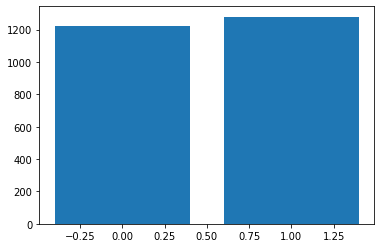

In [252]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
target_enc = LabelEncoder().fit_transform(target)
counter = Counter(target_enc)
for k,v in counter.items():
    per = v / len(target_enc) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### Dividiendo nuestro dataset en set de Entrenamiento y Pruebas

In [199]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=133)

Class=1, n=1005 (50.250%)
Class=0, n=995 (49.750%)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


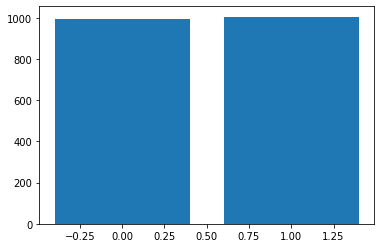

In [254]:
y_train_counter= LabelEncoder().fit_transform(y_train)
counter = Counter(y_train_counter)
for k,v in counter.items():
	per = v / len(y_train_counter) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### Entrenando un modelo ``DecisionTreeClassifier()``

In [255]:
# Método para creacion de modelos basados en arbol de desición
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
d_train=lgb.Dataset(X_train, label=y_train)
#setting up the parameters
params={}
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=10
#training the model
clf=lgb.train(params,d_train,100)


#forest=ExtraTreesClassifier(random_state=1,max_depth=8,n_estimators=100,min_samples_split=10,min_samples_leaf=1)
#n_estimators = [100]
#max_depth = [8]
#min_samples_split = [10]
#min_samples_leaf = [1] 
#dtc = RFECV(estimator=forest, step=1, cv=StratifiedKFold(5), scoring='accuracy')
#Randomforest(n_estimators=300)
#hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#              min_samples_split = min_samples_split, 
#             min_samples_leaf = min_samples_leaf)

#dtc = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                     # n_jobs = -1)
#dtc.fit(X_train, y_train)

### Haciendo predicciones del Sample Test

In [256]:
#y_pred = dtc.predict(X_test)
#print(y_pred)
y_pred=clf.predict(X_test)
y_pred=y_pred.round(0)
y_pred=y_pred.astype(int)

In [ ]:
dtc.best_params_

{'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

### Analice la calidad del modelo a través de la matriz de confusión

In [ ]:
!pip install seaborn --upgrade

Text(0.5, 15.0, 'Predicted label\n\nAccuracy=0.834\nPrecision=0.824\nRecall=0.887\nF1 Score=0.8546409807355516')

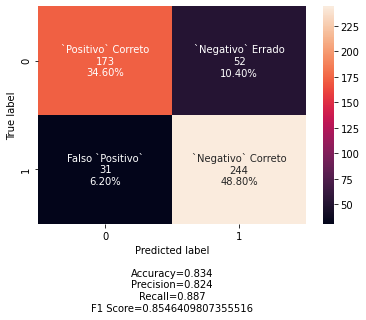

In [257]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['`Positivo` Correto', '`Negativo` Errado', 'Falso `Positivo`', '`Negativo` Correto']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
recall    = cf_matrix[1,1] / sum(cf_matrix[1,:])
f1_score  = 2*precision*recall / (precision + recall)
sns.heatmap(cf_matrix, annot=labels, fmt="")
stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={}".format(accuracy, precision, recall, f1_score)
plt.ylabel('True label')
plt.xlabel('Predicted label' + stats_text)

In [203]:
print('Optimal number of features: {}'.format(dtc.n_features_))

Optimal number of features: 4


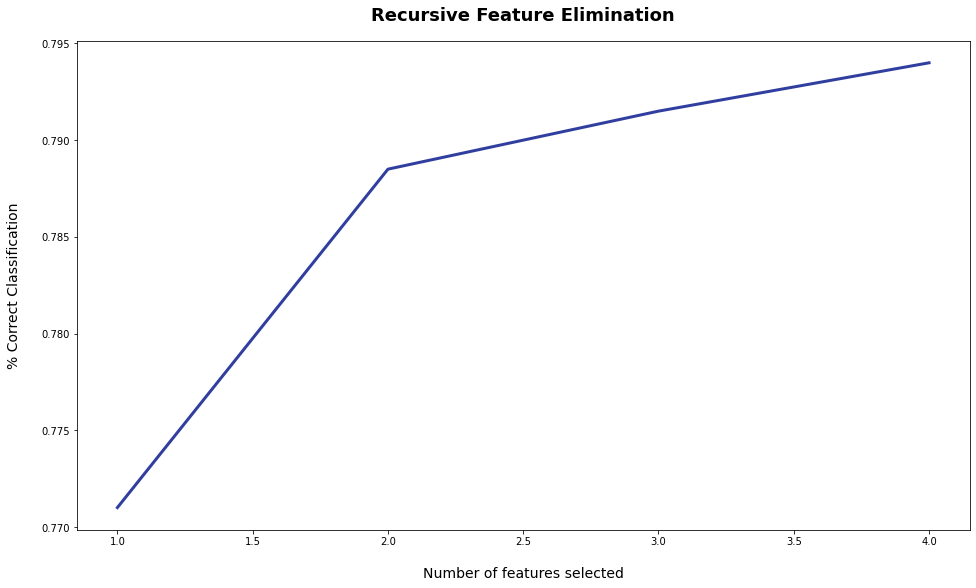

In [204]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(dtc.grid_scores_) + 1), dtc.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


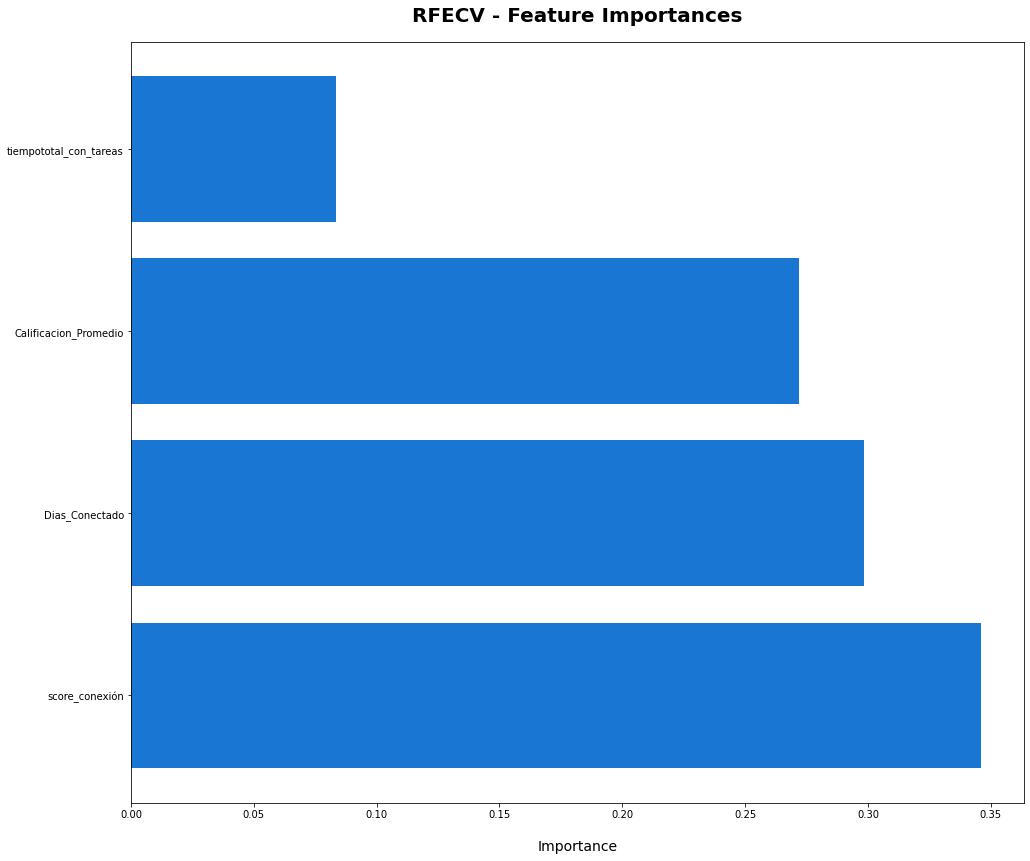

In [194]:
features.drop(features.columns[np.where(dtc.support_ == False)[0]], axis=1, inplace=True)
dset = pd.DataFrame()
dset['attr'] = features.columns
dset['importance'] = dtc.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [ ]:
df_feature_importance = pd.DataFrame(dtc.estimator_.feature_importances_, index=features.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance.plot(kind='barh');

ValueError: Shape of passed values is (13, 1), indices imply (14, 1)

<hr>

## Scoring de la data requerida para hacer la entrega de la solución

Para el envío, necesita clasificar el siguiente dataset. Para hacer eso, usted necesita reproducir los mismos pasos de pre-procesamiento para que el dataset este en la misma estructura del que usted uso para construir su modelo. Despues de clasificar este dataframe, esperamos que usted entregue un archivo csv con las 2499 filar y una columna 'Graduado' con su predicción. **No cambie el orden del archivo a predecir ni borre filas**

In [258]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset2/master/for_submission/ToBePredicted.csv
df_to_be_predicted = pd.read_csv(r'ToBePredicted.csv')
df_to_be_predicted.tail()

--2020-09-18 06:54:59--  https://raw.githubusercontent.com/vanderlei-test/dataset2/master/for_submission/ToBePredicted.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33892 (33K) [text/plain]
Saving to: ‘ToBePredicted.csv.1’

ToBePredicted.csv.1 100%[===================>]  33.10K  --.-KB/s    in 0.01s   

2020-09-18 06:54:59 (2.50 MB/s) - ‘ToBePredicted.csv.1’ saved [33892/33892]



,studentId,reducido,ciclo
995,79594.0,Diagn. Psicoped.,2019 - 05
996,69470.0,Ventas Estrat.,2018 - 08
997,72921.0,Big Data,2019 - 02
998,80608.0,Interv. Psicoped,2019 - 05
999,86966.0,Interv. Psicoped,2019 - 07


In [259]:
# Uniendo los dataset
df = pd.merge(
    df_to_be_predicted, df_tabla_tareas, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
    left_index=False, right_index=False, sort=True,
    suffixes=('_x', '_y'), copy=True, indicator=False,
    validate=None
)
df = pd.merge(
    df, df_tabla_conexiones, how='inner',
    on=None, left_on=['studentId', 'ciclo'], right_on=['studentId', 'ciclo'],
)
df = pd.merge(
    df, df_orden_materias, how='inner',
    on=None, left_on=['reducido', 'ciclo'], right_on=['reducido', 'variable'],
)
df=df.drop(['variable'], axis=1)



In [260]:
temporal=df['ciclo'].str.split('-', 1, expand=True)
temporal.columns=['año','ciclo']
df['año']=temporal['año']
df['ciclo']=temporal['ciclo']
df['ciclo']=df['ciclo'].astype(int)

In [261]:
le=LabelEncoder()
le.fit(df.año)
f=le.transform(df.año)
df['año']=f

In [262]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(df.reducido)
c=le.transform(df.reducido)
le.fit(df.value)
d=le.transform(df.value)
df['reducido']=c
df['value']=d

In [263]:
# Eliminando la columna 'reducido'
df2 = df.drop(columns=['studentId'], inplace=False)

# Columnas One-hot-encoding del dataset usando el metodo de Pandas ``get_dummies``  (demontración)
#df3 = pd.get_dummies(df2, columns=['ciclo'])
#df3.tail()

In [264]:
df2['score_de_no_cumplir']=df2['Calificacion_Promedio']*(df2['Tareas_No_Entregadas']+df2['Tareas_Retrasadas'])

In [265]:
df2['score_conexión']=df2['Calificacion_Promedio']*df2['Dias_Conectado']

In [266]:
df2['tiempo_de_no_cumplir']=df2['Minutos_Promedio']*(df2['Tareas_No_Entregadas']+df2['Tareas_Retrasadas'])

In [267]:
df2['tiempototal_con_tareas']=df2['Total_Tareas']*df2['Minutos_Total']*df2['Calificacion_Promedio']

In [268]:
df2['puntajes_promedios']=df2['Calificacion_Promedio']*df2['Tareas_Puntuales']*df2['Minutos_Promedio']

In [216]:
df2.columns

Index(['reducido', 'ciclo', 'Calificacion_Promedio', 'Tareas_Puntuales',
       'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
       'Dias_Conectado', 'Minutos_Promedio', 'Minutos_Total', 'value', 'año',
       'score_de_no_cumplir', 'score_conexión', 'tiempo_de_no_cumplir',
       'tiempototal_con_tareas', 'puntajes_promedios'],
      dtype='object')

Observando los features declarados acontinuación, sabemos que el dataset ha ser evaluado esta en el mismo formato usado para entrenar nuestro árbol de decisión anteriormente.

```features = df3[
    [
        'studentId', 'Calificacion_Promedio', 'Tareas_Puntuales',
        'Tareas_No_Entregadas', 'Tareas_Retrasadas', 'Total_Tareas',
        'ciclo_2017 - 03', 'ciclo_2017 - 04', 'ciclo_2017 - 05',
        'ciclo_2017 - 06', 'ciclo_2017 - 07', 'ciclo_2017 - 08',
        'ciclo_2018 - 01', 'ciclo_2018 - 02', 'ciclo_2018 - 03',
        'ciclo_2018 - 04', 'ciclo_2018 - 05', 'ciclo_2018 - 06',
        'ciclo_2018 - 07', 'ciclo_2018 - 08', 'ciclo_2019 - 01',
        'ciclo_2019 - 02', 'ciclo_2019 - 03', 'ciclo_2019 - 04',
        'ciclo_2019 - 05', 'ciclo_2019 - 06', 'ciclo_2019 - 07',
        'ciclo_2019 - 08'
    ]
]
target = df3['Graduado']  ## No cambie la variable target!```

In [270]:
y_pred = clf.predict(df2[
    [
        'Calificacion_Promedio',
        'Dias_Conectado',
       'score_conexión', 'tiempototal_con_tareas'
    ]
])
#print(y_pred)
y_pred=y_pred.round(0)
y_pred=y_pred.astype(int)

In [271]:
y_pred=np.where(y_pred==1,'Si','No')

### Guardando los resultados de la predicción en un archivo csv

In [272]:
np.savetxt("results.csv", y_pred, delimiter=",", fmt='%s')

In [220]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [273]:
data=pd.read_csv("results.csv", header=None)

In [274]:
data.to_csv('/content/drive/My Drive/Colab Notebooks/Desafio 6/results.csv',header=["TARGET"], index=False)

In [ ]:
project.save_data(file_name="results.csv", data=pd.read_csv("results.csv", header=None).to_csv(header=["TARGET"], index=False))

{'file_name': 'results.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'desafio6-donotdelete-pr-iniypbssahwokt',
 'asset_id': '9bbb2fdf-403c-495e-88ad-aee461c147b0'}

<hr>

## ¡Felicitaciones!

Si todo fue ejecutado sin errores, usted ya tiene un modelo basado en classificacion binaria y puede descargar sus resultados para subirlos como csv!

Para enviar su solución, ve a la página:

# https://anahuac.maratona.dev
